The first step in the process is getting the open MDC1 par and tim files in the tests directory

In [1]:
import glob
import os
from enterprise.signals import parameter
from enterprise.signals import white_signals 
from enterprise.signals import gp_signals 
from enterprise.signals import utils         
from enterprise.signals import signal_base    
from enterprise.pulsar import Pulsar 
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
from enterprise_extensions.blocks import white_noise_block, red_noise_block, dm_noise_block
import numpy as np
import corner

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
parfiles_700= sorted(glob.glob('/data/' + 'test_3.par'))
timfiles_700 = sorted(glob.glob('/data/'+ 'combined.tim'))

Создается объект psr и добавляется в список

In [3]:
psrs = []
for p, t in zip(parfiles_700, timfiles_700):
    psr = Pulsar(p, t)
    print(psr)
    psrs.append(psr)
    print(psrs)

In [4]:
# Uniform prior on EFAC
efac = parameter.Uniform(0.1,5.0)

# # red noise parameters
# # Uniform in log10 Amplitude and in spectral index
# log10_A = parameter.Uniform(-18,-12) #Равномерное априорное распределение для амплитуды красного шума
# gamma = parameter.Uniform(0,7)#Равномерное распределение для спектрального индекса красного шума

# ##### Set up signals #####

# # white noise
# ef = white_signals.MeasurementNoise(efac=efac) #Создаётcя компонента белого шума

# pl_dm = utils.powerlaw(log10_A=log10_A, gamma=gamma)
# dm = gp_signals.FourierBasisGP(spectrum=pl_dm, components=30)

# # timing model
# tm = gp_signals.TimingModel() #Добавляет временную модель пульсара (учёт вращения, положения и других параметров из par файла).


# # full model is sum of components
# model = ef + dm + tm

# s = gp_signals.TimingModel()

# s += dm_noise_block(components=30)
# s += white_noise_block(vary=False, select=None) # select=None



# model = s
tmin = [p.toas.min() for p in psrs]
tmax = [p.toas.max() for p in psrs]
Tspan = np.max(tmax) - np.min(tmin)
log10_A_dm = parameter.Uniform(-20, -11)
gamma_dm = parameter.Uniform(0, 7)
dm_prior = utils.powerlaw(log10_A=log10_A_dm, gamma=gamma_dm)
dm_basis = utils.createfourierdesignmatrix_dm(nmodes=30, Tspan=Tspan)
dmgp = gp_signals.BasisGP(dm_prior, dm_basis, name='dm_gp', coefficients=False)
ef = white_signals.MeasurementNoise(efac=efac)
tm = gp_signals.TimingModel()
model = ef + dmgp + tm

# initialize PTA
pta_700 = signal_base.PTA([model(psrs[0])]) #cоздаёт объект PTA для первого пульсара из списка psrs

In [5]:
print(pta_700.params)

[fake_test_3_dm_gp_gamma:Uniform(pmin=0, pmax=7), fake_test_3_dm_gp_log10_A:Uniform(pmin=-20, pmax=-11), fake_test_3_efac:Uniform(pmin=0.1, pmax=5.0)]


создает словарь со случайными начальными значениями параметров для MCMC-сэмплера

In [6]:
xs_700 = {par.name: par.sample() for par in pta_700.params} #Перебирает все параметры модели.

#par.name: Получает имя параметра
#par.sample(): Генерирует случайное значение параметра согласно его априорному распределению 
print(xs_700)


{'fake_test_3_dm_gp_gamma': 2.826954128725756, 'fake_test_3_dm_gp_log10_A': -12.836498173391618, 'fake_test_3_efac': 2.814745571334427}


In [7]:
# # dimension of parameter space
ndim = len(xs_700)

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2) #Создаёт диагональную матрицу размерности ndim x ndim с элементами 0.0001задаёт начальный размер "шага" сэмплера по каждому параметру 

# # set up jump groups by red noise groups
ndim = len(xs_700)
groups  = [range(0, ndim)]#создаёт группу из всех параметров
groups.extend([[0,1]])#добавляет отдельную группу для параметров с индексами 1 и 2, Ускоряет сходимость, обновляя коррелированные параметры (например, амплитуду и спектральный индекс) совместно.
# intialize sampler
sampler = ptmcmc(ndim, pta_700.get_lnlikelihood, pta_700.get_lnprior, cov, groups=groups, outDir='/data')

In [8]:
# sampler for N steps
N = 100000 #общее количество итераций MCMC
x0 = np.hstack(p.sample() for p in pta_700.params) 
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

Finished 0.00 percent in 0.001951 s Acceptance rate = 0

/tmp/ipykernel_56082/3408449239.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  x0 = np.hstack(p.sample() for p in pta_700.params)


Finished 1.00 percent in 0.503003 s Acceptance rate = 0.845

/usr/local/lib/python3.10/dist-packages/enterprise/signals/parameter.py:70: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Adding DE jump with weight 5037460 s Acceptance rate = 0.22828
Finished 100.00 percent in 39.342149 s Acceptance rate = 0.37204
Run Complete


In [9]:
chain = np.loadtxt('/data/chain_1.txt') #загружаются данные цепочки MCMC из файла
pars = sorted(xs_700.keys())
burn = int(0.25 * chain.shape[0])#первые 25% шагов цепочки отбрасываются 

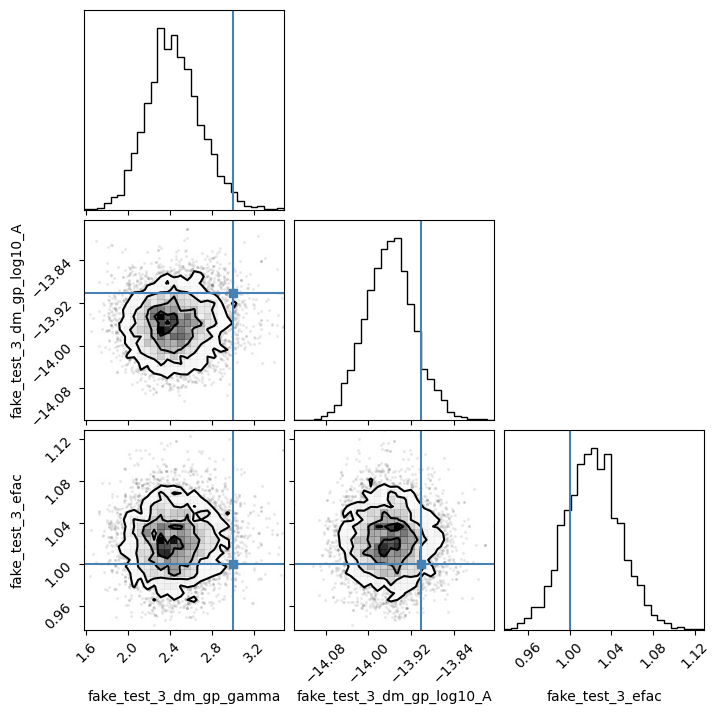

In [11]:
truths = [3, np.log10(5e-12)-2.6, 1.0]#задаются эталонные значения параметров для сравнения с результатами MCMC.
corner.corner(chain[burn:,:-4], 30, truths=truths, labels=pars);